In [1]:
import torch
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
from geomloss import SamplesLoss
from torch import optim
from torchvision.datasets import CIFAR10
import torch
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
from geomloss import SamplesLoss
from torch import optim


# Define a function to project weights to a simplex
def project_to_simplex(weights):
    return torch.clamp(weights, min=0) / torch.sum(weights)

def project_simplex(v):
        """
        v: PyTorch Tensor to be projected to a simplex

        Returns:
        w: PyTorch Tensor simplex projection of v
        """
        z = 1
        orig_shape = v.shape
        v = v.view(1, -1)
        shape = v.shape
        with torch.no_grad():
            mu = torch.sort(v, dim=1)[0]
            mu = torch.flip(mu, dims=(1,))
            cum_sum = torch.cumsum(mu, dim=1)
            j = torch.unsqueeze(torch.arange(1, shape[1] + 1, dtype=mu.dtype, device=mu.device), 0)
            rho = torch.sum(mu * j - cum_sum + z > 0.0, dim=1, keepdim=True) - 1.
            rho = rho.to(int)
            max_nn = cum_sum[torch.arange(shape[0]), rho[:, 0]]
            theta = (torch.unsqueeze(max_nn, -1) - z) / (rho.type(max_nn.dtype) + 1)
            w = torch.clamp(v - theta, min=0.0).view(orig_shape)
            return w
        
transform = transforms.Compose(
    [transforms.Grayscale(),
     transforms.ToTensor(),
     transforms.Normalize((0.5,), (0.5,))])

cifar_trainset = CIFAR10(root='data/', download=True, transform=transform)
subset = torch.utils.data.Subset(cifar_trainset, range(42000))
unlabeled, target = torch.utils.data.random_split(subset, [40000, 2000])

# Filter target dataset to include only one label, e.g., 0
target_images, target_labels = zip(*target)
label_to_keep = 9
print("Target Label:{}".format(label_to_keep))
filtered_target_indices = [i for i, label in enumerate(target_labels) if label == label_to_keep]
target_images_org = [target_images[i] for i in filtered_target_indices]
target_images = torch.stack(target_images_org)
print("No of target images:{}".format(target_images.shape[0]))

unlabeled_images, unlabeled_labels = zip(*unlabeled)
unlabeled_images = torch.stack(unlabeled_images)
unlabeled_loader = DataLoader(list(zip(unlabeled_images, unlabeled_labels)), batch_size=4000, shuffle=False)

target_loader = DataLoader(target_images, batch_size=len(target_images), shuffle=False)

# Create a loss function using GeomLoss
sinkhorn_loss = SamplesLoss(loss="sinkhorn", p=2, blur=0.01)

# Initialize weights for the unlabeled_images
weights_unlabeled = torch.full((len(unlabeled), 1), 1.0 / len(unlabeled), requires_grad=True)
weights_target = torch.full((len(target_images), 1), 1.0 / len(target), requires_grad=False)

# Define an optimizer
#optimizer = optim.SGD([weights_unlabeled], lr=0.001)
optimizer = optim.Adam([weights_unlabeled], lr=0.01)

# Loop over the datasets 10 times
for epoch in range(10):

    losses = []
    weights_unlabeled.grad = None  # Reset gradients at the beginning of each epoch

    for batch_idx, ((unlabeled_images, _),target_images) in enumerate(zip(unlabeled_loader, target_loader)):
        optimizer.zero_grad()  # Reset gradients

        # Select the weights for the current batch
        unlabeled_images = unlabeled_images[:,0,:,:]
        target_images = target_images[:,0,:,:]
        weights_batch = weights_unlabeled[batch_idx * unlabeled_loader.batch_size : (batch_idx + 1) * unlabeled_loader.batch_size]
        weights_batch = weights_batch.clone() / weights_batch.sum()

        # Reshape the images to be 1D tensors
        unlabeled_images = unlabeled_images.view(unlabeled_images.shape[0], -1)
        target_images = target_images.view(target_images.shape[0], -1)


        # Compute Sinkhorn loss
        loss = sinkhorn_loss(weights_batch,unlabeled_images.view(unlabeled_images.shape[0], -1), weights_target,
                             target_images.view(target_images.shape[0], -1),
                             )

        losses.append(loss.item())

        # Compute gradients for the loss
        loss.backward()  # Gradients are accumulated over mini-batches

    # Average the loss over all mini-batches
    loss_avg = sum(losses) / len(losses)

    # Update the weights based on the accumulated gradients
    optimizer.step()

    # Project the weights to a simplex
    with torch.no_grad():
        weights_unlabeled.data = project_simplex(weights_unlabeled.data)
    
    #weights_unlabeled = weights_unlabeled_new.clone().detach().requires_grad_(True)

    print(f"Epoch {epoch+1}, Average Sinkhorn loss: {loss_avg}")

# Sort the weights in descending order and print the non-zero weights
sorted_weights, indices = torch.sort(weights_unlabeled.flatten(), descending=True)
top_weights = sorted_weights[:10]
top_indices = indices[:10]

# Retrieve the labels of the images corresponding to the top indices
top_labels = [unlabeled_labels[idx] for idx in top_indices]

print("Top 10 weights, their indices, and corresponding labels:")
for weight, idx, label in zip(top_weights, top_indices, top_labels):
    print(f"Weight: {weight}, Index: {idx}, Label: {label}")

Files already downloaded and verified
Target Label:9
No of target images:200
Epoch 1, Average Sinkhorn loss: 9271.09765625
Epoch 2, Average Sinkhorn loss: 9255.0703125
Epoch 3, Average Sinkhorn loss: 9252.1484375
Epoch 4, Average Sinkhorn loss: 9247.1044921875
Epoch 5, Average Sinkhorn loss: 9244.13671875
Epoch 6, Average Sinkhorn loss: 9243.0244140625
Epoch 7, Average Sinkhorn loss: 9242.146484375
Epoch 8, Average Sinkhorn loss: 9241.0302734375
Epoch 9, Average Sinkhorn loss: 9239.998046875
Epoch 10, Average Sinkhorn loss: 9239.4033203125
Top 10 weights, their indices, and corresponding labels:
Weight: 0.019431760534644127, Index: 3189, Label: 4
Weight: 0.018872834742069244, Index: 1140, Label: 4
Weight: 0.013660362921655178, Index: 2342, Label: 4
Weight: 0.009914053604006767, Index: 3590, Label: 0
Weight: 0.009910528548061848, Index: 3127, Label: 0
Weight: 0.0093167619779706, Index: 2934, Label: 4
Weight: 0.008644971996545792, Index: 2155, Label: 3
Weight: 0.008335231803357601, Index

In [10]:
!pip install matplotlib

Looking in indexes: https://pypi.org/simple, https://packagecloud.io/github/git-lfs/pypi/simple
  Using cached matplotlib-3.7.1-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (11.6 MB)
  Using cached contourpy-1.0.7-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (300 kB)
  Using cached cycler-0.11.0-py3-none-any.whl (6.4 kB)
  Using cached fonttools-4.39.4-py3-none-any.whl (1.0 MB)
  Using cached kiwisolver-1.4.4-cp310-cp310-manylinux_2_12_x86_64.manylinux2010_x86_64.whl (1.6 MB)
  Using cached pyparsing-3.0.9-py3-none-any.whl (98 kB)


In [20]:
import torch
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
from geomloss import SamplesLoss
from torch import optim
from torchvision.datasets import CIFAR10

# Define a function to project weights to a simplex
def project_simplex(v):
    z = 1
    orig_shape = v.shape
    v = v.view(1, -1)
    shape = v.shape
    with torch.no_grad():
        mu = torch.sort(v, dim=1)[0]
        mu = torch.flip(mu, dims=(1,))
        cum_sum = torch.cumsum(mu, dim=1)
        j = torch.unsqueeze(torch.arange(1, shape[1] + 1, dtype=mu.dtype, device=mu.device), 0)
        rho = torch.sum(mu * j - cum_sum + z > 0.0, dim=1, keepdim=True) - 1.
        rho = rho.to(int)
        max_nn = cum_sum[torch.arange(shape[0]), rho[:, 0]]
        theta = (torch.unsqueeze(max_nn, -1) - z) / (rho.type(max_nn.dtype) + 1)
        w = torch.clamp(v - theta, min=0.0).view(orig_shape)
        return w
        
transform = transforms.Compose(
    [transforms.Grayscale(),
     transforms.ToTensor(),
     transforms.Normalize((0.5,), (0.5,))])

cifar_trainset = CIFAR10(root='data/', download=True, transform=transform)
subset = torch.utils.data.Subset(cifar_trainset, range(50000))
unlabeled, remaining = torch.utils.data.random_split(subset, [40000, 10000])

# split remaining into target and private
target, private = torch.utils.data.random_split(remaining, [5000, 5000])

# Filter target dataset to include only one label, e.g., 0
target_images, target_labels = zip(*target)
label_to_keep = 9
print("Target Label:{}".format(label_to_keep))
filtered_target_indices = [i for i, label in enumerate(target_labels) if label == label_to_keep]
target_images_org = [target_images[i] for i in filtered_target_indices]
target_images = torch.stack(target_images_org)
print("No of target and private images:{}".format(target_images.shape[0]))

unlabeled_images, unlabeled_labels = zip(*unlabeled)
unlabeled_images = torch.stack(unlabeled_images)
unlabeled_loader = DataLoader(list(zip(unlabeled_images, unlabeled_labels)), batch_size=2000, shuffle=False)

target_loader = DataLoader(target_images, batch_size=len(target_images), shuffle=False)

# Filter private dataset to exclude label_to_keep
private_images, private_labels = zip(*private)
filtered_private_indices = [i for i, label in enumerate(private_labels) if label != label_to_keep]
private_images_org = [private_images[i] for i in filtered_private_indices]
private_images = torch.stack(private_images_org[:len(target_images)])

private_loader = DataLoader(private_images, batch_size=len(private_images), shuffle=False)

# Create a loss function using GeomLoss
sinkhorn_loss = SamplesLoss(loss="sinkhorn", p=2, blur=0.01)

# Initialize weights for the unlabeled_images and private_images
weights_unlabeled = torch.full((len(unlabeled), 1), 1.0 / len(unlabeled), requires_grad=True)
weights_target = torch.full((len(target_images), 1), 1.0 / len(target), requires_grad=False)
weights_private = torch.full((len(private_images), 1), 1.0 / len(private), requires_grad=False)

# Define an optimizer
optimizer = optim.Adam([weights_unlabeled], lr=0.1)

# Loop over the datasets 10 times
for epoch in range(100):

    losses = []
    weights_unlabeled.grad = None  # Reset gradients at the beginning of each epoch

    for batch_idx, ((unlabeled_images, _), target_images, private_images) in enumerate(zip(unlabeled_loader, target_loader, private_loader)):
        optimizer.zero_grad()  # Reset gradients

        # Select the weights for the current batch
        unlabeled_images = unlabeled_images[:,0,:,:]
        target_images = target_images[:,0,:,:]
        private_images = private_images[:,0,:,:]
        weights_batch = weights_unlabeled[batch_idx * unlabeled_loader.batch_size : (batch_idx + 1) * unlabeled_loader.batch_size]
        weights_batch = weights_batch.clone() / weights_batch.sum()

        # Reshape the images to be 1D tensors
        unlabeled_images = unlabeled_images.view(unlabeled_images.shape[0], -1)
        target_images = target_images.view(target_images.shape[0], -1)
        private_images = private_images.view(private_images.shape[0], -1)

        # Compute Sinkhorn loss
        loss_unlabeled_target = sinkhorn_loss(weights_batch, unlabeled_images, weights_target, target_images)
        loss_unlabeled_private = sinkhorn_loss(weights_batch, unlabeled_images, weights_private, private_images)
        loss_private_target = sinkhorn_loss(weights_private, private_images, weights_target, target_images)

        loss = loss_unlabeled_target + loss_unlabeled_private # - loss_private_target

        losses.append(loss.item())

        # Compute gradients for the loss
        loss.backward()  # Gradients are accumulated over mini-batches

    # Average the loss over all mini-batches
    loss_avg = sum(losses) / len(losses)

    # Update the weights based on the accumulated gradients
    optimizer.step()

    # Project the weights to a simplex
    with torch.no_grad():
        weights_unlabeled.data = project_simplex(weights_unlabeled.data)

    print(f"Epoch {epoch+1}, Average Sinkhorn loss: {loss_avg}")

# Sort the weights in descending order and print the non-zero weights
sorted_weights, indices = torch.sort(weights_unlabeled.flatten(), descending=True)
top_weights = sorted_weights[:10]
top_indices = indices[:10]

# Retrieve the labels of the images corresponding to the top indices
top_labels = [unlabeled_labels[idx] for idx in top_indices]

print("Top 10 weights, their indices, and corresponding labels:")
for weight, idx, label in zip(top_weights, top_indices, top_labels):
    print(f"Weight: {weight}, Index: {idx}, Label: {label}")


Files already downloaded and verified
Target Label:9
No of target and private images:493
Epoch 1, Average Sinkhorn loss: 18639.896484375
Epoch 2, Average Sinkhorn loss: 18618.90234375
Epoch 3, Average Sinkhorn loss: 18660.529296875
Epoch 4, Average Sinkhorn loss: 18647.70703125
Epoch 5, Average Sinkhorn loss: 18643.46484375
Epoch 6, Average Sinkhorn loss: 18632.1328125
Epoch 7, Average Sinkhorn loss: 18633.99609375
Epoch 8, Average Sinkhorn loss: 18643.685546875
Epoch 9, Average Sinkhorn loss: 18637.29296875
Epoch 10, Average Sinkhorn loss: 18627.28515625
Epoch 11, Average Sinkhorn loss: 18619.453125
Epoch 12, Average Sinkhorn loss: 18617.82421875
Epoch 13, Average Sinkhorn loss: 18614.515625
Epoch 14, Average Sinkhorn loss: 18610.994140625
Epoch 15, Average Sinkhorn loss: 18609.37109375
Epoch 16, Average Sinkhorn loss: 18606.986328125
Epoch 17, Average Sinkhorn loss: 18606.1015625
Epoch 18, Average Sinkhorn loss: 18603.21875
Epoch 19, Average Sinkhorn loss: 18603.29296875
Epoch 20, Av

In [13]:
top_weights = sorted_weights[:40]
top_indices = indices[:40]

# Retrieve the labels of the images corresponding to the top indices
top_labels = [unlabeled_labels[idx] for idx in top_indices]

print("Top 10 weights, their indices, and corresponding labels:")
for weight, idx, label in zip(top_weights, top_indices, top_labels):
    print(f"Weight: {weight}, Index: {idx}, Label: {label}")

Top 10 weights, their indices, and corresponding labels:
Weight: 0.09060194343328476, Index: 656, Label: 9
Weight: 0.07091376930475235, Index: 1530, Label: 9
Weight: 0.05342164263129234, Index: 300, Label: 9
Weight: 0.047572292387485504, Index: 311, Label: 9
Weight: 0.0457182377576828, Index: 1379, Label: 1
Weight: 0.04495656117796898, Index: 224, Label: 8
Weight: 0.04354281350970268, Index: 865, Label: 9
Weight: 0.03724737837910652, Index: 1613, Label: 8
Weight: 0.035446733236312866, Index: 841, Label: 9
Weight: 0.03486665338277817, Index: 1855, Label: 9
Weight: 0.031335748732089996, Index: 167, Label: 8
Weight: 0.028674567118287086, Index: 729, Label: 3
Weight: 0.018840136006474495, Index: 220, Label: 8
Weight: 0.018701745197176933, Index: 151, Label: 9
Weight: 0.018684063106775284, Index: 278, Label: 9
Weight: 0.018663911148905754, Index: 1999, Label: 0
Weight: 0.016198843717575073, Index: 907, Label: 1
Weight: 0.014517731964588165, Index: 1762, Label: 0
Weight: 0.01014022808521986,

In [28]:
import torch
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
from geomloss import SamplesLoss
from torch import optim
from torchvision.datasets import CIFAR10

# Define a function to project weights to a simplex
def project_simplex(v):
    z = 1
    orig_shape = v.shape
    v = v.view(1, -1)
    shape = v.shape
    with torch.no_grad():
        mu = torch.sort(v, dim=1)[0]
        mu = torch.flip(mu, dims=(1,))
        cum_sum = torch.cumsum(mu, dim=1)
        j = torch.unsqueeze(torch.arange(1, shape[1] + 1, dtype=mu.dtype, device=mu.device), 0)
        rho = torch.sum(mu * j - cum_sum + z > 0.0, dim=1, keepdim=True) - 1.
        rho = rho.to(int)
        max_nn = cum_sum[torch.arange(shape[0]), rho[:, 0]]
        theta = (torch.unsqueeze(max_nn, -1) - z) / (rho.type(max_nn.dtype) + 1)
        w = torch.clamp(v - theta, min=0.0).view(orig_shape)
        return w

transform = transforms.Compose(
    [
     #conver to grayscale,
    transforms.Grayscale(num_output_channels=1),
     transforms.ToTensor(),
     transforms.Normalize((0.5,), (0.5,))])

cifar_trainset = CIFAR10(root='data/', download=True, transform=transform)
subset = torch.utils.data.Subset(cifar_trainset, range(10000))
unlabeled, remaining = torch.utils.data.random_split(subset, [4000, 6000])

# split remaining into target and private
target, private = torch.utils.data.random_split(remaining, [3000, 3000])

# Filter target dataset to include only one label, e.g., 0
target_images, target_labels = zip(*target)
label_to_keep = 9
print("Target Label:{}".format(label_to_keep))
filtered_target_indices = [i for i, label in enumerate(target_labels) if label == label_to_keep]
target_images_org = [target_images[i] for i in filtered_target_indices]
target_images = torch.stack(target_images_org)
print("No of target and private images:{}".format(target_images.shape[0]))

unlabeled_images, unlabeled_labels = zip(*unlabeled)
unlabeled_images = torch.stack(unlabeled_images)
unlabeled_loader = DataLoader(list(zip(unlabeled_images, unlabeled_labels)), batch_size=4000, shuffle=False)

target_loader = DataLoader(target_images, batch_size=len(target_images), shuffle=False)

# Filter private dataset to exclude label_to_keep
private_images, private_labels = zip(*private)
filtered_private_indices = [i for i, label in enumerate(private_labels) if label != label_to_keep]
private_images_org = [private_images[i] for i in filtered_private_indices]
private_images = torch.stack(private_images_org[:len(target_images)])

private_loader = DataLoader(private_images, batch_size=len(private_images), shuffle=False)

# Create a loss function using GeomLoss
sinkhorn_loss = SamplesLoss(loss="sinkhorn", p=2, blur=0.01)

# Initialize weights for the unlabeled_images for target and private
weights_unlabeled_target = torch.full((len(unlabeled), 1), 1.0 / len(unlabeled), requires_grad=True)
weights_unlabeled_private = torch.full((len(unlabeled), 1), 1.0 / len(unlabeled), requires_grad=True)
weights_target = torch.full((len(target_images), 1), 1.0 / len(target), requires_grad=False)
weights_private = torch.full((len(private_images), 1), 1.0 / len(private), requires_grad=False)

# Define an optimizer for each set of weights
optimizer_target = optim.Adam([weights_unlabeled_target], lr=.1)
optimizer_private = optim.Adam([weights_unlabeled_private], lr=.1)

# Define the learning rate scheduler
scheduler_target = torch.optim.lr_scheduler.StepLR(optimizer_target, step_size=10, gamma=0.1)
scheduler_private = torch.optim.lr_scheduler.StepLR(optimizer_private, step_size=10, gamma=0.1)

# Loop over the datasets 10 times
for epoch in range(100):

    losses = []
    weights_unlabeled_target.grad = None  # Reset gradients at the beginning of each epoch
    weights_unlabeled_private.grad = None  # Reset gradients at the beginning of each epoch

    for batch_idx, ((unlabeled_images, _), target_images, private_images) in enumerate(zip(unlabeled_loader, target_loader, private_loader)):
        optimizer_target.zero_grad()  # Reset gradients
        optimizer_private.zero_grad()  # Reset gradients

        # Select the weights for the current batch
        unlabeled_images = unlabeled_images[:,0,:,:]
        target_images = target_images[:,0,:,:]
        private_images = private_images[:,0,:,:]
        weights_batch_target = weights_unlabeled_target[batch_idx * unlabeled_loader.batch_size : (batch_idx + 1) * unlabeled_loader.batch_size]
        weights_batch_target = weights_batch_target.clone() / weights_batch_target.sum()
        weights_batch_private = weights_unlabeled_private[batch_idx * unlabeled_loader.batch_size : (batch_idx + 1) * unlabeled_loader.batch_size]
        weights_batch_private = weights_batch_private.clone() / weights_batch_private.sum()

        # Reshape the images to be 1D tensors
        unlabeled_images = unlabeled_images.view(unlabeled_images.shape[0], -1)
        target_images = target_images.view(target_images.shape[0], -1)
        private_images = private_images.view(private_images.shape[0], -1)

        # Compute Sinkhorn loss
        loss_unlabeled_target = sinkhorn_loss(weights_batch_target, unlabeled_images, weights_target, target_images)
        loss_unlabeled_private = sinkhorn_loss(weights_batch_private, unlabeled_images, weights_private, private_images)
        loss_private_target = sinkhorn_loss(weights_batch_target, unlabeled_images, weights_batch_private, unlabeled_images)

        loss = loss_unlabeled_target + loss_unlabeled_private - loss_private_target
        print(f"Loss unlabeled-target: {loss_unlabeled_target.item()}, Loss unlabeled-private: {loss_unlabeled_private.item()}, Loss private-target: {loss_private_target.item()}")
        losses.append(loss.item())

        # Compute gradients for the loss
        loss.backward()  # Gradients are accumulated over mini-batches

        
       
    # Average the loss over all mini-batches
    loss_avg = sum(losses) / len(losses)
   
    # Update the weights based on the accumulated gradients
    optimizer_target.step()
    optimizer_private.step()

    # Step the learning rate scheduler
    scheduler_target.step()
    scheduler_private.step()
    
   
    
    


    # Project the weights to a simplex
    with torch.no_grad():
        weights_unlabeled_target.data = project_simplex(weights_unlabeled_target.data)
        weights_unlabeled_private.data = project_simplex(weights_unlabeled_private.data)

    print(f"Epoch {epoch+1}, Average Sinkhorn loss: {loss_avg}")

    # Sort the weights in descending order and print the non-zero weights
    sorted_weights_target, indices_target = torch.sort(weights_unlabeled_target.flatten(), descending=True)
    top_weights_target = sorted_weights_target[:10]
    top_indices_target = indices_target[:10]

    sorted_weights_private, indices_private = torch.sort(weights_unlabeled_private.flatten(), descending=True)
    top_weights_private = sorted_weights_private[:10]
    top_indices_private = indices_private[:10]

    # Retrieve the labels of the images corresponding to the top indices
    top_labels_target = [unlabeled_labels[idx] for idx in top_indices_target]
    top_labels_private = [unlabeled_labels[idx] for idx in top_indices_private]

    print("Top 10 weights for target, their indices, and corresponding labels:")
    for weight, idx, label in zip(top_weights_target, top_indices_target, top_labels_target):
        print(f"Weight: {weight}, Index: {idx}, Label: {label}")

    print("Top 10 weights for private, their indices, and corresponding labels:")
    for weight, idx, label in zip(top_weights_private, top_indices_private, top_labels_private):
        print(f"Weight: {weight}, Index: {idx}, Label: {label}")


Files already downloaded and verified
Target Label:9
No of target and private images:295
Loss unlabeled-target: 9350.7939453125, Loss unlabeled-private: 9333.3935546875, Loss private-target: 0.0
Epoch 1, Average Sinkhorn loss: 18684.1875
Top 10 weights for target, their indices, and corresponding labels:
Weight: 0.000449255108833313, Index: 822, Label: 7
Weight: 0.000449255108833313, Index: 2093, Label: 1
Weight: 0.000449255108833313, Index: 1808, Label: 6
Weight: 0.000449255108833313, Index: 2114, Label: 1
Weight: 0.000449255108833313, Index: 1553, Label: 8
Weight: 0.000449255108833313, Index: 3536, Label: 0
Weight: 0.000449255108833313, Index: 2873, Label: 1
Weight: 0.000449255108833313, Index: 2292, Label: 7
Weight: 0.000449255108833313, Index: 3018, Label: 6
Weight: 0.000449255108833313, Index: 2890, Label: 4
Top 10 weights for private, their indices, and corresponding labels:
Weight: 0.00044054538011550903, Index: 379, Label: 9
Weight: 0.00044054538011550903, Index: 592, Label: 2


# Masking gradients

In [3]:
import torch
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
from geomloss import SamplesLoss
from torch import optim
from torchvision.datasets import CIFAR10

# Define a function to project weights to a simplex
def project_simplex(v):
    z = 1
    orig_shape = v.shape
    v = v.view(1, -1)
    shape = v.shape
    with torch.no_grad():
        mu = torch.sort(v, dim=1)[0]
        mu = torch.flip(mu, dims=(1,))
        cum_sum = torch.cumsum(mu, dim=1)
        j = torch.unsqueeze(torch.arange(1, shape[1] + 1, dtype=mu.dtype, device=mu.device), 0)
        rho = torch.sum(mu * j - cum_sum + z > 0.0, dim=1, keepdim=True) - 1.
        rho = rho.to(int)
        max_nn = cum_sum[torch.arange(shape[0]), rho[:, 0]]
        theta = (torch.unsqueeze(max_nn, -1) - z) / (rho.type(max_nn.dtype) + 1)
        w = torch.clamp(v - theta, min=0.0).view(orig_shape)
        return w

transform = transforms.Compose(
    [
     transforms.ToTensor(),
     transforms.Normalize((0.5,), (0.5,))])

cifar_trainset = CIFAR10(root='data/', download=True, transform=transform)
subset = torch.utils.data.Subset(cifar_trainset, range(42000))
unlabeled, remaining = torch.utils.data.random_split(subset, [40000, 2000])

# split remaining into target and private
target, private = torch.utils.data.random_split(remaining, [1000, 1000])

# Filter target dataset to include only one label, e.g., 0
target_images, target_labels = zip(*target)
label_to_keep = 9
print("Target Label:{}".format(label_to_keep))
filtered_target_indices = [i for i, label in enumerate(target_labels) if label == label_to_keep]
target_images_org = [target_images[i] for i in filtered_target_indices]
target_images = torch.stack(target_images_org)
print("No of target and private images:{}".format(target_images.shape[0]))

unlabeled_images, unlabeled_labels = zip(*unlabeled)
unlabeled_images = torch.stack(unlabeled_images)
unlabeled_loader = DataLoader(list(zip(unlabeled_images, unlabeled_labels)), batch_size=4000, shuffle=False)

target_loader = DataLoader(target_images, batch_size=len(target_images), shuffle=False)

# Filter private dataset to exclude label_to_keep
private_images, private_labels = zip(*private)
filtered_private_indices = [i for i, label in enumerate(private_labels) if label != label_to_keep]
private_images_org = [private_images[i] for i in filtered_private_indices]
private_images = torch.stack(private_images_org[:len(target_images)])

private_loader = DataLoader(private_images, batch_size=len(private_images), shuffle=False)

# Create a loss function using GeomLoss
sinkhorn_loss = SamplesLoss(loss="sinkhorn", p=2, blur=0.01)

# Initialize weights for the unlabeled_images for target and private
weights_unlabeled_target = torch.full((len(unlabeled), 1), 1.0 / len(unlabeled), requires_grad=True)
weights_unlabeled_private = torch.full((len(unlabeled), 1), 1.0 / len(unlabeled), requires_grad=True)
weights_target = torch.full((len(target_images), 1), 1.0 / len(target), requires_grad=False)
weights_private = torch.full((len(private_images), 1), 1.0 / len(private), requires_grad=False)

# Define an optimizer for each set of weights
optimizer_target = optim.SGD([weights_unlabeled_target,weights_unlabeled_private], lr=0.01)
#optimizer_private = optim.Adam([weights_unlabeled_private], lr=0.01)

# Loop over the datasets 10 times
for epoch in range(100):

    losses = []
    weights_unlabeled_target.grad = None  # Reset gradients at the beginning of each epoch
    weights_unlabeled_private.grad = None  # Reset gradients at the beginning of each epoch

    for batch_idx, ((unlabeled_images, _), target_images, private_images) in enumerate(zip(unlabeled_loader, target_loader, private_loader)):
        optimizer_target.zero_grad()  # Reset gradients
        

        # Select the weights for the current batch
        unlabeled_images = unlabeled_images[:,0,:,:]
        target_images = target_images[:,0,:,:]
        private_images = private_images[:,0,:,:]
        weights_batch_target = weights_unlabeled_target[batch_idx * unlabeled_loader.batch_size : (batch_idx + 1) * unlabeled_loader.batch_size]
        weights_batch_target = weights_batch_target.clone() / weights_batch_target.sum()
        weights_batch_private = weights_unlabeled_private[batch_idx * unlabeled_loader.batch_size : (batch_idx + 1) * unlabeled_loader.batch_size]
        weights_batch_private = weights_batch_private.clone() / weights_batch_private.sum()

        # Reshape the images to be 1D tensors
        unlabeled_images = unlabeled_images.view(unlabeled_images.shape[0], -1)
        target_images = target_images.view(target_images.shape[0], -1)
        private_images = private_images.view(private_images.shape[0], -1)

        # Compute Sinkhorn loss
        loss_unlabeled_target = sinkhorn_loss(weights_batch_target, unlabeled_images, weights_target, target_images)
        loss_unlabeled_private = sinkhorn_loss(weights_batch_private, unlabeled_images, weights_private, private_images)
        #loss_private_target = sinkhorn_loss(weights_batch_target, unlabeled_images, weights_batch_private, unlabeled_images)

        loss = loss_unlabeled_target + loss_unlabeled_private #- loss_private_target
        #print(f"Loss unlabeled-target: {loss_unlabeled_target.item()}, Loss unlabeled-private: {loss_unlabeled_private.item()}, Loss private-target: {loss_private_target.item()}")
        print(f"Loss unlabeled-target: {loss_unlabeled_target.item()}, Loss unlabeled-private: {loss_unlabeled_private.item()}")
        losses.append(loss.item())

        # Compute gradients for the loss
        loss.backward()  # Gradients are accumulated over mini-batches

        # Create a mask for weights_unlabeled_target and weights_unlabeled_private
        
        mask_target = torch.zeros_like(weights_unlabeled_target)
        mask_target[batch_idx * unlabeled_loader.batch_size : (batch_idx + 1) * unlabeled_loader.batch_size] = 1.0
        mask_private = torch.zeros_like(weights_unlabeled_private)
        mask_private[batch_idx * unlabeled_loader.batch_size : (batch_idx + 1) * unlabeled_loader.batch_size] = 1.0
        
        # Apply the masks to the gradients
        weights_unlabeled_target.grad *= mask_target
        weights_unlabeled_private.grad *= mask_private
        
        # Update the weights based on the accumulated gradients
        optimizer_target.step()
     

    # Average the loss over all mini-batches
    loss_avg = sum(losses) / len(losses)
   
    
    
   
   

    # Project the weights to a simplex
    with torch.no_grad():
        weights_unlabeled_target.data = project_simplex(weights_unlabeled_target.data)
        weights_unlabeled_private.data = project_simplex(weights_unlabeled_private.data)

    print(f"Epoch {epoch+1}, Average Sinkhorn loss: {loss_avg}")

    print('if selected at this epoch, the weights and labels are:')

    # Sort the weights in descending order and print the non-zero weights
    sorted_weights_target, indices_target = torch.sort(weights_unlabeled_target.flatten(), descending=True)
    top_weights_target = sorted_weights_target[:10]
    top_indices_target = indices_target[:10]

    sorted_weights_private, indices_private = torch.sort(weights_unlabeled_private.flatten(), descending=True)
    top_weights_private = sorted_weights_private[:10]
    top_indices_private = indices_private[:10]

    # Retrieve the labels of the images corresponding to the top indices
    top_labels_target = [unlabeled_labels[idx] for idx in top_indices_target]
    top_labels_private = [unlabeled_labels[idx] for idx in top_indices_private]

    print("Top 10 weights for target, their indices, and corresponding labels:")
    for weight, idx, label in zip(top_weights_target, top_indices_target, top_labels_target):
        print(f"Weight: {weight}, Index: {idx}, Label: {label}")

    print("Top 10 weights for private, their indices, and corresponding labels:")
    for weight, idx, label in zip(top_weights_private, top_indices_private, top_labels_private):
        print(f"Weight: {weight}, Index: {idx}, Label: {label}")
    #if loss is zero or less quit
    #if loss_avg <= 0:
    #    break


# Sort the weights in descending order and print the non-zero weights
sorted_weights_target, indices_target = torch.sort(weights_unlabeled_target.flatten(), descending=True)
top_weights_target = sorted_weights_target[:10]
top_indices_target = indices_target[:10]

sorted_weights_private, indices_private = torch.sort(weights_unlabeled_private.flatten(), descending=True)
top_weights_private = sorted_weights_private[:10]
top_indices_private = indices_private[:10]

# Retrieve the labels of the images corresponding to the top indices
top_labels_target = [unlabeled_labels[idx] for idx in top_indices_target]
top_labels_private = [unlabeled_labels[idx] for idx in top_indices_private]

print("Top 10 weights for target, their indices, and corresponding labels:")
for weight, idx, label in zip(top_weights_target, top_indices_target, top_labels_target):
    print(f"Weight: {weight}, Index: {idx}, Label: {label}")

print("Top 10 weights for private, their indices, and corresponding labels:")
for weight, idx, label in zip(top_weights_private, top_indices_private, top_labels_private):
    print(f"Weight: {weight}, Index: {idx}, Label: {label}")


Files already downloaded and verified
Target Label:9
No of target and private images:97
Loss unlabeled-target: 9431.6884765625, Loss unlabeled-private: 9414.3544921875
Difference in target weights:  tensor([[-1.0638],
        [ 1.9217],
        [ 5.4746],
        ...,
        [ 0.0000],
        [ 0.0000],
        [ 0.0000]], grad_fn=<SubBackward0>)
Difference in target weights:  tensor([[-4.8985]], grad_fn=<SliceBackward0>)
Difference in target weights:  tensor([[-4.8985],
        [-4.1365]], grad_fn=<SliceBackward0>)
Difference in target weights:  tensor([[-4.8985],
        [-4.1365],
        [-0.9508]], grad_fn=<SliceBackward0>)
Difference in target weights:  tensor([[2.2868],
        [0.0000],
        [0.0000],
        [0.0000],
        [0.0000],
        [0.0000]], grad_fn=<SliceBackward0>)
Difference in target weights:  tensor([[2.2868],
        [0.0000],
        [0.0000]], grad_fn=<SliceBackward0>)


# Balanced Dataset

In [3]:
import torch
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
from geomloss import SamplesLoss
from torch import optim
from torchvision.datasets import CIFAR10
import random

# Define a function to project weights to a simplex
def project_simplex(v):
    z = 1
    orig_shape = v.shape
    v = v.view(1, -1)
    shape = v.shape
    with torch.no_grad():
        mu = torch.sort(v, dim=1)[0]
        mu = torch.flip(mu, dims=(1,))
        cum_sum = torch.cumsum(mu, dim=1)
        j = torch.unsqueeze(torch.arange(1, shape[1] + 1, dtype=mu.dtype, device=mu.device), 0)
        rho = torch.sum(mu * j - cum_sum + z > 0.0, dim=1, keepdim=True) - 1.
        rho = rho.to(int)
        max_nn = cum_sum[torch.arange(shape[0]), rho[:, 0]]
        theta = (torch.unsqueeze(max_nn, -1) - z) / (rho.type(max_nn.dtype) + 1)
        w = torch.clamp(v - theta, min=0.0).view(orig_shape)
        return w

transform = transforms.Compose(
    [
     #conver to grayscale,
    transforms.Grayscale(num_output_channels=1),
     transforms.ToTensor(),
     transforms.Normalize((0.5,), (0.5,))])

# Get the whole CIFAR10 dataset
cifar_trainset = CIFAR10(root='data/', download=True, transform=transform)

# Split the whole CIFAR10 dataset based on class labels into ten subsets
class_datasets = [[] for _ in range(10)]
for image, label in cifar_trainset:
    class_datasets[label].append((image, label))

target_size = 100
print('target and private datasets size is:',target_size)
# For the target dataset, pick 100 samples from one class
target_class = 9
target_dataset = class_datasets[target_class][:target_size]
class_datasets[target_class] = class_datasets[target_class][target_size:]

# For the private dataset, pick 10 samples each from the remaining 9 classes
private_size = 10
private_dataset = []
for class_num, class_dataset in enumerate(class_datasets):
    if class_num != target_class:
        private_dataset.extend(class_dataset[:private_size])
        class_datasets[class_num] = class_dataset[private_size:]



# The unlabeled dataset will contain the remaining samples
unlabeled_dataset = [sample for class_dataset in class_datasets for sample in class_dataset]

# Shuffle the datasets
random.shuffle(unlabeled_dataset)
random.shuffle(private_dataset)
random.shuffle(target_dataset)

unlabeled_size = 10000
print('unlabeled dataset size is:',unlabeled_size)

# Create DataLoaders for each dataset
unlabeled_loader = DataLoader(unlabeled_dataset[:unlabeled_size], batch_size=4000, shuffle=False)
target_loader = DataLoader(target_dataset, batch_size=len(target_dataset), shuffle=False)
private_loader = DataLoader(private_dataset, batch_size=len(private_dataset), shuffle=False)


# Create a loss function using GeomLoss
sinkhorn_loss = SamplesLoss(loss="sinkhorn", p=2, blur=0.01)

# Initialize weights for the unlabeled_images for target and private
weights_unlabeled_target = torch.full((len(unlabeled_dataset), 1), 1.0 / len(unlabeled_dataset), requires_grad=True)
weights_unlabeled_private = torch.full((len(unlabeled_dataset), 1), 1.0 / len(unlabeled_dataset), requires_grad=True)
weights_target = torch.full((len(target_dataset), 1), 1.0 / len(target_dataset), requires_grad=False)
weights_private = torch.full((len(private_dataset), 1), 1.0 / len(private_dataset), requires_grad=False)

# Define an optimizer for each set of weights
optimizer_target = optim.Adam([weights_unlabeled_target,weights_target], lr=.01)
optimizer_private = optim.Adam([weights_unlabeled_private,weights_private], lr=.01)

# Define the learning rate scheduler
#scheduler_target = torch.optim.lr_scheduler.StepLR(optimizer_target, step_size=10, gamma=0.1)
#scheduler_private = torch.optim.lr_scheduler.StepLR(optimizer_private, step_size=10, gamma=0.1)

# Create lists to store the loss values
loss_values_unlabeled_target = []
loss_values_unlabeled_private = []
loss_values_private_target = []


# Loop over the datasets 10 times
for epoch in range(100):

    losses = []
    weights_unlabeled_target.grad = None  # Reset gradients at the beginning of each epoch
    weights_unlabeled_private.grad = None  # Reset gradients at the beginning of each epoch

    for batch_idx, batch in enumerate(zip(unlabeled_loader, target_loader, private_loader)):
        unlabeled_images, _ = batch[0]
        target_images, _ = batch[1]
        private_images, _ = batch[2]
        optimizer_target.zero_grad()  # Reset gradients
        optimizer_private.zero_grad()  # Reset gradients

        # Select the weights for the current batch
        unlabeled_images = unlabeled_images[:,0,:,:]
        target_images = target_images[:,0,:,:]
        private_images = private_images[:,0,:,:]
        weights_batch_target = weights_unlabeled_target[batch_idx * unlabeled_loader.batch_size : (batch_idx + 1) * unlabeled_loader.batch_size]
        weights_batch_target = weights_batch_target.clone() / weights_batch_target.sum()
        weights_batch_private = weights_unlabeled_private[batch_idx * unlabeled_loader.batch_size : (batch_idx + 1) * unlabeled_loader.batch_size]
        weights_batch_private = weights_batch_private.clone() / weights_batch_private.sum()

        # Reshape the images to be 1D tensors
        unlabeled_images = unlabeled_images.view(unlabeled_images.shape[0], -1)
        target_images = target_images.view(target_images.shape[0], -1)
        private_images = private_images.view(private_images.shape[0], -1)

        # Compute Sinkhorn loss
        loss_unlabeled_target = sinkhorn_loss(weights_batch_target, unlabeled_images, weights_target, target_images)
        loss_unlabeled_private = sinkhorn_loss(weights_batch_private, unlabeled_images, weights_private, private_images)
        loss_private_target = sinkhorn_loss(weights_batch_target, unlabeled_images, weights_batch_private, unlabeled_images)

        # Compute Sinkhorn loss
        loss_unlabeled_target = sinkhorn_loss(weights_batch_target, unlabeled_images, weights_target, target_images)
        loss_unlabeled_private = sinkhorn_loss(weights_batch_private, unlabeled_images, weights_private, private_images)
        loss_private_target = sinkhorn_loss(weights_batch_target, unlabeled_images, weights_batch_private, unlabeled_images)

        loss_values_unlabeled_target.append(loss_unlabeled_target.item())
        loss_values_unlabeled_private.append(loss_unlabeled_private.item())
        loss_values_private_target.append(loss_private_target.item())


        loss = loss_unlabeled_target + loss_unlabeled_private - loss_private_target
        print(f"Loss unlabeled-target: {loss_unlabeled_target.item()}, Loss unlabeled-private: {loss_unlabeled_private.item()}, Loss private-target: {loss_private_target.item()}")
        losses.append(loss.item())

        # Compute gradients for the loss
        loss.backward()  # Gradients are accumulated over mini-batches

        
       
    # Average the loss over all mini-batches
    loss_avg = sum(losses) / len(losses)
   
    # Update the weights based on the accumulated gradients
    optimizer_target.step()
    optimizer_private.step()

    # Step the learning rate scheduler
    #scheduler_target.step()
    #scheduler_private.step()
    
   
    
    


    # Project the weights to a simplex
    with torch.no_grad():
        weights_unlabeled_target.data = project_simplex(weights_unlabeled_target.data)
        weights_unlabeled_private.data = project_simplex(weights_unlabeled_private.data)

    print(f"Epoch {epoch+1}, Average Sinkhorn loss: {loss_avg}")

    # Sort the weights in descending order and print the non-zero weights
    sorted_weights_target, indices_target = torch.sort(weights_unlabeled_target.flatten(), descending=True)
    top_weights_target = sorted_weights_target[:10]
    top_indices_target = indices_target[:10]

    sorted_weights_private, indices_private = torch.sort(weights_unlabeled_private.flatten(), descending=True)
    top_weights_private = sorted_weights_private[:10]
    top_indices_private = indices_private[:10]

    # Retrieve the labels of the images corresponding to the top indices
    top_labels_target = [unlabeled_labels[idx] for idx in top_indices_target]
    top_labels_private = [unlabeled_labels[idx] for idx in top_indices_private]

    print("Top 10 weights for target, their indices, and corresponding labels:")
    for weight, idx, label in zip(top_weights_target, top_indices_target, top_labels_target):
        print(f"Weight: {weight}, Index: {idx}, Label: {label}")

    print("Top 10 weights for private, their indices, and corresponding labels:")
    for weight, idx, label in zip(top_weights_private, top_indices_private, top_labels_private):
        print(f"Weight: {weight}, Index: {idx}, Label: {label}")

import matplotlib.pyplot as plt

# Create a figure and a set of subplots
fig, ax = plt.subplots()

# Plot the loss values
ax.plot(loss_values_unlabeled_target, label='Unlabeled-Target Loss')
ax.plot(loss_values_unlabeled_private, label='Unlabeled-Private Loss')
ax.plot(loss_values_private_target, label='Private-Target Loss')

# Set the labels and title
ax.set_xlabel('Epochs')
ax.set_ylabel('Loss')
ax.set_title('Loss curves')

# Add a legend
ax.legend()

# Show the plot
plt.show()



Files already downloaded and verified
target and private datasets size is: 100
unlabeled dataset size is: 10000
Loss unlabeled-target: 129.8899383544922, Loss unlabeled-private: 101.36668395996094, Loss private-target: 0.0
Epoch 1, Average Sinkhorn loss: 231.25662231445312


NameError: name 'unlabeled_labels' is not defined

# based on Resnet18 Features

Files already downloaded and verified
target and private datasets size is: 10
unlabeled dataset size is: 1000


/home/venkat/sinkhorn-minibatch/.venv/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/venkat/sinkhorn-minibatch/.venv/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /home/venkat/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100.0%


Loss unlabeled-target: 2047.744873046875, Loss unlabeled-private: 1283.548828125, Loss private-target: 0.0
Epoch 1, Average Sinkhorn loss: 3331.293701171875
Top 10 weights for target, their indices, and corresponding labels:
Weight: 0.004629634320735931, Index: 317, Label: 8
Weight: 0.004629634320735931, Index: 293, Label: 8
Weight: 0.004629630595445633, Index: 253, Label: 2
Weight: 0.004629630595445633, Index: 202, Label: 0
Weight: 0.004629630595445633, Index: 206, Label: 1
Weight: 0.004629630595445633, Index: 90, Label: 8
Weight: 0.004629630595445633, Index: 87, Label: 9
Weight: 0.004629630595445633, Index: 214, Label: 4
Weight: 0.004629630595445633, Index: 226, Label: 1
Weight: 0.004629630595445633, Index: 73, Label: 1
Top 10 weights for private, their indices, and corresponding labels:
Weight: 0.00444445013999939, Index: 209, Label: 2
Weight: 0.004444446414709091, Index: 250, Label: 7
Weight: 0.004444446414709091, Index: 177, Label: 7
Weight: 0.004444446414709091, Index: 368, Label

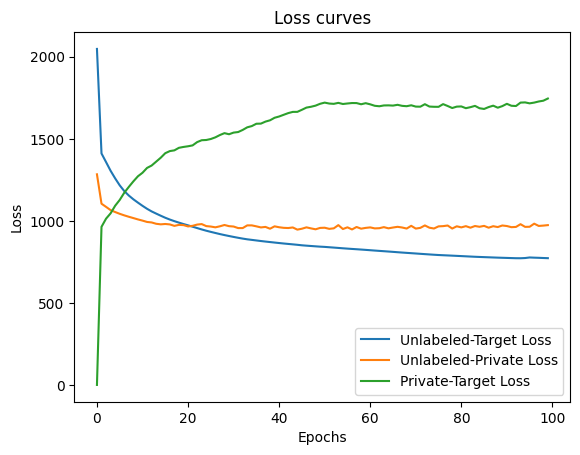

In [21]:
import torch
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
from geomloss import SamplesLoss
from torch import optim
from torchvision.datasets import CIFAR10
import random
from torchvision.models import resnet50

# Define a function to project weights to a simplex
def project_simplex(v):
    z = 1
    orig_shape = v.shape
    v = v.view(1, -1)
    shape = v.shape
    with torch.no_grad():
        mu = torch.sort(v, dim=1)[0]
        mu = torch.flip(mu, dims=(1,))
        cum_sum = torch.cumsum(mu, dim=1)
        j = torch.unsqueeze(torch.arange(1, shape[1] + 1, dtype=mu.dtype, device=mu.device), 0)
        rho = torch.sum(mu * j - cum_sum + z > 0.0, dim=1, keepdim=True) - 1.
        rho = rho.to(int)
        max_nn = cum_sum[torch.arange(shape[0]), rho[:, 0]]
        theta = (torch.unsqueeze(max_nn, -1) - z) / (rho.type(max_nn.dtype) + 1)
        w = torch.clamp(v - theta, min=0.0).view(orig_shape)
        return w

transform = transforms.Compose(
    [
     transforms.Resize((224, 224)),
     transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
    ])
# Get the whole CIFAR10 dataset
cifar_trainset = CIFAR10(root='data/', download=True, transform=transform)

# Split the whole CIFAR10 dataset based on class labels into ten subsets
class_datasets = [[] for _ in range(10)]
for image, label in cifar_trainset:
    class_datasets[label].append((image, label))

target_size = 100
print('target and private datasets size is:',target_size)
# For the target dataset, pick 100 samples from one class
target_class = 8
target_dataset = class_datasets[target_class][:target_size]
class_datasets[target_class] = class_datasets[target_class][target_size:]

# For the private dataset, pick 10 samples each from the remaining 9 classes
private_size = 10
private_dataset = []
for class_num, class_dataset in enumerate(class_datasets):
    if class_num != target_class:
        private_dataset.extend(class_dataset[:private_size])
        class_datasets[class_num] = class_dataset[private_size:]



# The unlabeled dataset will contain the remaining samples
unlabeled_dataset = [(image, label) for class_dataset in class_datasets for image, label in class_dataset]


# Shuffle the datasets
random.shuffle(unlabeled_dataset)
random.shuffle(private_dataset)
random.shuffle(target_dataset)
# Get the labels for the unlabeled dataset
unlabeled_labels = [label for _, label in unlabeled_dataset]
unlabeled_size = 10000
print('unlabeled dataset size is:',unlabeled_size)

# Create DataLoaders for each dataset
unlabeled_loader = DataLoader(unlabeled_dataset[:unlabeled_size], batch_size=4000, shuffle=False)
target_loader = DataLoader(target_dataset, batch_size=len(target_dataset), shuffle=False)
private_loader = DataLoader(private_dataset, batch_size=len(private_dataset), shuffle=False)

# Load the pretrained ResNet18 model
model = resnet50(pretrained=True)

# Set the model to evaluation mode
model.eval()


# Create a loss function using GeomLoss
sinkhorn_loss = SamplesLoss(loss="sinkhorn", p=2, blur=0.01)

# Initialize weights for the unlabeled_images for target and private
weights_unlabeled_target = torch.full((len(unlabeled_dataset), 1), 1.0 / len(unlabeled_dataset), requires_grad=True)
weights_unlabeled_private = torch.full((len(unlabeled_dataset), 1), 1.0 / len(unlabeled_dataset), requires_grad=True)
weights_target = torch.full((len(target_dataset), 1), 1.0 / len(target_dataset), requires_grad=False)
weights_private = torch.full((len(private_dataset), 1), 1.0 / len(private_dataset), requires_grad=False)

# Define an optimizer for each set of weights
optimizer_target = optim.Adam([weights_unlabeled_target], lr=.05)
optimizer_private = optim.Adam([weights_unlabeled_private], lr=.05)

# Define the learning rate scheduler
#scheduler_target = torch.optim.lr_scheduler.StepLR(optimizer_target, step_size=10, gamma=0.1)
#scheduler_private = torch.optim.lr_scheduler.StepLR(optimizer_private, step_size=10, gamma=0.1)

# Create lists to store the loss values
loss_values_unlabeled_target = []
loss_values_unlabeled_private = []
loss_values_private_target = []


# Loop over the datasets 10 times
for epoch in range(100):

    losses = []
    weights_unlabeled_target.grad = None  # Reset gradients at the beginning of each epoch
    weights_unlabeled_private.grad = None  # Reset gradients at the beginning of each epoch

    for batch_idx, batch in enumerate(zip(unlabeled_loader, target_loader, private_loader)):
        unlabeled_images, _ = batch[0]
        target_images, _ = batch[1]
        private_images, _ = batch[2]
         # Don't calculate gradients
        with torch.no_grad():
            # Get the features using the pretrained model
            unlabeled_features = model(unlabeled_images)
            target_features = model(target_images)
            private_features = model(private_images)

        optimizer_target.zero_grad()  # Reset gradients
        optimizer_private.zero_grad()  # Reset gradients

        # Select the weights for the current batch
        unlabeled_images = unlabeled_images[:,0,:,:]
        target_images = target_images[:,0,:,:]
        private_images = private_images[:,0,:,:]
        weights_batch_target = weights_unlabeled_target[batch_idx * unlabeled_loader.batch_size : (batch_idx + 1) * unlabeled_loader.batch_size]
        weights_batch_target = weights_batch_target.clone() / weights_batch_target.sum()
        weights_batch_private = weights_unlabeled_private[batch_idx * unlabeled_loader.batch_size : (batch_idx + 1) * unlabeled_loader.batch_size]
        weights_batch_private = weights_batch_private.clone() / weights_batch_private.sum()

        # Reshape the images to be 1D tensors
        unlabeled_images = unlabeled_images.view(unlabeled_images.shape[0], -1)
        target_images = target_images.view(target_images.shape[0], -1)
        private_images = private_images.view(private_images.shape[0], -1)

        # Flatten the features to be 1D tensors
        unlabeled_features = unlabeled_features.view(unlabeled_features.shape[0], -1)
        target_features = target_features.view(target_features.shape[0], -1)
        private_features = private_features.view(private_features.shape[0], -1)


      
        # Compute Sinkhorn loss
        loss_unlabeled_target = sinkhorn_loss(weights_batch_target, unlabeled_features, weights_target, target_features)
        loss_unlabeled_private = sinkhorn_loss(weights_batch_private, unlabeled_features, weights_private, private_features)
        loss_private_target = sinkhorn_loss(weights_batch_target, unlabeled_features, weights_batch_private, unlabeled_features)

        loss_values_unlabeled_target.append(loss_unlabeled_target.item())
        loss_values_unlabeled_private.append(loss_unlabeled_private.item())
        loss_values_private_target.append(loss_private_target.item())


        loss = loss_unlabeled_target #+ loss_unlabeled_private #- loss_private_target
        print(f"Loss unlabeled-target: {loss_unlabeled_target.item()}, Loss unlabeled-private: {loss_unlabeled_private.item()}, Loss private-target: {loss_private_target.item()}")
        losses.append(loss.item())

        # Compute gradients for the loss
        loss.backward()  # Gradients are accumulated over mini-batches

        
       
    # Average the loss over all mini-batches
    loss_avg = sum(losses) / len(losses)
   
    # Update the weights based on the accumulated gradients
    optimizer_target.step()
    optimizer_private.step()

    # Step the learning rate scheduler
    #scheduler_target.step()
    #scheduler_private.step()
    
   
    
    


    # Project the weights to a simplex
    with torch.no_grad():
        weights_unlabeled_target.data = project_simplex(weights_unlabeled_target.data)
        weights_unlabeled_private.data = project_simplex(weights_unlabeled_private.data)

    print(f"Epoch {epoch+1}, Average Sinkhorn loss: {loss_avg}")

    # Sort the weights in descending order and print the non-zero weights
    sorted_weights_target, indices_target = torch.sort(weights_unlabeled_target.flatten(), descending=True)
    top_weights_target = sorted_weights_target[:10]
    top_indices_target = indices_target[:10]

    sorted_weights_private, indices_private = torch.sort(weights_unlabeled_private.flatten(), descending=True)
    top_weights_private = sorted_weights_private[:10]
    top_indices_private = indices_private[:10]

    # Retrieve the labels of the images corresponding to the top indices
    top_labels_target = [unlabeled_labels[idx] for idx in top_indices_target]
    top_labels_private = [unlabeled_labels[idx] for idx in top_indices_private]

    print("Top 10 weights for target, their indices, and corresponding labels:")
    for weight, idx, label in zip(top_weights_target, top_indices_target, top_labels_target):
        print(f"Weight: {weight}, Index: {idx}, Label: {label}")

    print("Top 10 weights for private, their indices, and corresponding labels:")
    for weight, idx, label in zip(top_weights_private, top_indices_private, top_labels_private):
        print(f"Weight: {weight}, Index: {idx}, Label: {label}")

import matplotlib.pyplot as plt

# Create a figure and a set of subplots
fig, ax = plt.subplots()

# Plot the loss values
ax.plot(loss_values_unlabeled_target, label='Unlabeled-Target Loss')
ax.plot(loss_values_unlabeled_private, label='Unlabeled-Private Loss')
ax.plot(loss_values_private_target, label='Private-Target Loss')

# Set the labels and title
ax.set_xlabel('Epochs')
ax.set_ylabel('Loss')
ax.set_title('Loss curves')

# Add a legend
ax.legend()

# Show the plot
plt.show()



In [22]:
# Sort the weights in descending order and print the non-zero weights
sorted_weights_target, indices_target = torch.sort(weights_unlabeled_target.flatten(), descending=True)
top_weights_target = sorted_weights_target[:50]
top_indices_target = indices_target[:50]

sorted_weights_private, indices_private = torch.sort(weights_unlabeled_private.flatten(), descending=True)
top_weights_private = sorted_weights_private[:10]
top_indices_private = indices_private[:10]

# Retrieve the labels of the images corresponding to the top indices
top_labels_target = [unlabeled_labels[idx] for idx in top_indices_target]
top_labels_private = [unlabeled_labels[idx] for idx in top_indices_private]

print("Top 10 weights for target, their indices, and corresponding labels:")
for weight, idx, label in zip(top_weights_target, top_indices_target, top_labels_target):
    print(f"Weight: {weight}, Index: {idx}, Label: {label}")

print("Top 10 weights for private, their indices, and corresponding labels:")
for weight, idx, label in zip(top_weights_private, top_indices_private, top_labels_private):
    print(f"Weight: {weight}, Index: {idx}, Label: {label}")


Top 10 weights for target, their indices, and corresponding labels:
Weight: 0.05479510873556137, Index: 191, Label: 8
Weight: 0.054446157068014145, Index: 218, Label: 8
Weight: 0.05198626592755318, Index: 161, Label: 8
Weight: 0.05070014297962189, Index: 220, Label: 0
Weight: 0.04282199591398239, Index: 84, Label: 8
Weight: 0.041471775621175766, Index: 270, Label: 8
Weight: 0.040421802550554276, Index: 155, Label: 8
Weight: 0.03953088819980621, Index: 294, Label: 8
Weight: 0.03757203742861748, Index: 7, Label: 0
Weight: 0.03627287223935127, Index: 293, Label: 8
Weight: 0.03597024083137512, Index: 202, Label: 0
Weight: 0.03538652881979942, Index: 311, Label: 1
Weight: 0.03500286862254143, Index: 244, Label: 9
Weight: 0.03377138078212738, Index: 51, Label: 8
Weight: 0.03110051341354847, Index: 372, Label: 0
Weight: 0.026448426768183708, Index: 379, Label: 0
Weight: 0.026390859857201576, Index: 364, Label: 8
Weight: 0.026122702285647392, Index: 49, Label: 0
Weight: 0.019749175757169724, I